# Figure 2 - regression results
#### Christopher Callahan
#### Christopher.W.Callahan.GR@dartmouth.edu

#### Mechanics
Dependencies

In [2]:
import xarray as xr
import numpy as np
import sys
import os
import datetime
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import seaborn as sns
from rasterio import features
from affine import Affine
import geopandas as gp
import descartes
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from scipy import stats

Data location

In [3]:
loc_reg = "../Data/RegressionResults/"
loc_panel = "../Data/Panel/"

Years

In [4]:
y1_panel = 1954
y2_panel = 2019

#### Analysis/plotting

Panel data

In [5]:
data = pd.read_csv(loc_panel+"baseball_climate_data_"+str(y1_panel)+"-"+str(y2_panel)+".csv")
y1_final = 1962
data = data.loc[data.year>=y1_final,:]
data["total_hr"] = data["visitor_hr"] + data["home_hr"]
data["tx"] = data["tmax_hadisd"]*1.0

Regression results

In [6]:
coefs_df = pd.read_csv(loc_reg+"homeruns_tx_poisson_gametypes.csv",index_col=0)
beta = coefs_df.loc[coefs_df.types=="all_nodome","beta"].values[0]
se = coefs_df.loc[coefs_df.types=="all_nodome","se"].values[0]
nboot = 1000

Placebo results

In [7]:
#placebo_coefs_df = pd.read_csv(loc_reg+"homeruns_tx_poisson_gametypes_placebo.csv",index_col=0)
placebo_coefs_df = pd.read_csv(loc_reg+"homeruns_tx_poisson_gametypes_placebo_parkgroup.csv",index_col=0)

Mean home runs and tx

In [8]:
mean_hr = np.nanmean(data.total_hr.values)
mean_tx = np.nanmean(data.tx.values)

Resample coef, normal distribution

In [9]:
np.random.seed(100)
coefs_dist = np.random.normal(loc=beta,scale=se,size=nboot)

Calc Poisson results, centered on the mean

In [10]:
x = np.arange(-1,45+1,1)
center_ind = np.argmin(np.abs(x-mean_tx))
yhat = np.zeros((nboot,len(x)))
yhat_centered = np.zeros((nboot,len(x)))
for n in np.arange(0,nboot,1):
    yh = np.exp(x*coefs_dist[n])
    yhat[n,:] = yh
    # center on means
    yhat_centered[n,:] = yh - yh[center_ind] + mean_hr

Statcast results

In [11]:
#mean_total_hr = 2.38
mean_total_hits = 24.98

In [12]:
hr_prob_ols = pd.read_csv(loc_reg+"hr_probability_speed_angle_ols.csv",index_col=0)

In [13]:
hr_prob_ols

,beta,se,ci2_5,ci97_5
1,0.001642,0.000138,0.001371,0.001912


Time period results for comparison to statcast

In [14]:
time_period_coefs = pd.read_csv(loc_reg+"homeruns_tx_poisson_time_periods.csv",index_col=0)

In [15]:
mean_total_hr = np.mean(data.loc[(data.dome==0)&(data.year>=2015)&(data.year<=2019),"total_hr"].values)

In [16]:
mean_total_hr

2.375498449268941

In [17]:
hr_prob_ols*mean_total_hits

,beta,se,ci2_5,ci97_5
1,0.041006,0.003444,0.034256,0.047756


In [18]:
time_period_coefs.loc[(time_period_coefs.y1==2015)&(time_period_coefs.daynight=="both"),"beta"].values[0]*mean_total_hr

0.043503311257874516

Fig

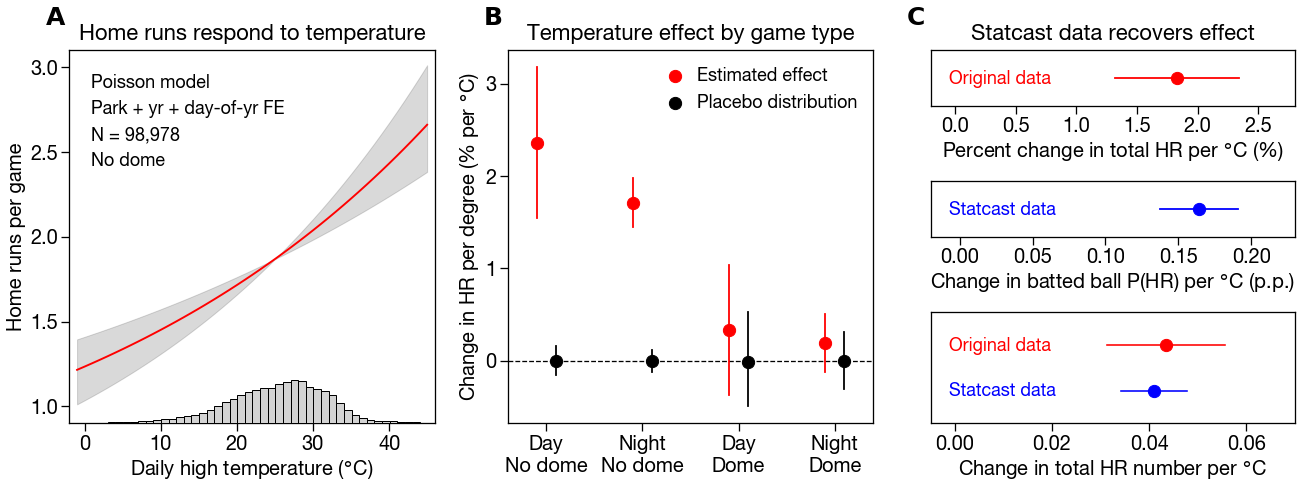

In [19]:
fig = plt.figure(figsize=(23,7))

rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Helvetica Neue"]
rcParams["font.size"] = 20.0
rcParams["axes.linewidth"] = 1.3
rcParams['xtick.major.size'] = 8
rcParams['xtick.major.width'] = 1.3
rcParams['ytick.major.size'] = 8
rcParams['ytick.major.width'] = 1.3

gs1 = gridspec.GridSpec(1,3)
gs1.update(left=0.15,right=0.9,top=0.87,bottom=0.13,wspace=0.2,hspace=0.3)

tfs = 22

## regression results
ax = plt.subplot(gs1[0,0])


yh_mean = np.mean(yhat_centered,axis=0)
yh_lower = np.percentile(yhat_centered,2.5,axis=0)
yh_upper = np.percentile(yhat_centered,97.5,axis=0)

plt.plot(x,yh_mean,color="red",linewidth=1.9)
ax.fill_between(x,yh_lower,yh_upper,color="black",alpha=0.15)

plt.xlabel("Daily high temperature ($\degree$C)")
plt.ylabel("Home runs per game")
xl = [-2,46]
plt.xlim(xl)
plt.ylim([0.9,3.1])
plt.yticks([1,1.5,2,2.5,3])
plt.title("Home runs respond to temperature",fontsize=tfs,pad=10)

plt.text(0.06,0.9,"Poisson model",fontsize=18,
         transform=ax.transAxes)
plt.text(0.06,0.83,"Park + yr + day-of-yr FE",fontsize=18,
         transform=ax.transAxes)
plt.text(0.06,0.76,"N = 98,978",fontsize=18,
         transform=ax.transAxes)
plt.text(0.06,0.69,"No dome",fontsize=18,
         transform=ax.transAxes)

## inset histogram at bottom
inset_ax = fig.add_axes([0.15,0.131,0.221,0.09])

bns = np.arange(-1,46+1,1)
inset_ax.hist(data.tx,color="lightgray",linewidth=1,
              edgecolor="black",bins=bns)

inset_ax.spines["right"].set_visible(False)
inset_ax.spines["top"].set_visible(False)
inset_ax.set_xlim(xl)
#inset_ax.set_ylim([0,35])
inset_ax.spines["bottom"].set_visible(False)
inset_ax.spines["left"].set_visible(False)
inset_ax.set_yticks([])
inset_ax.set_xticks([])
inset_ax.patch.set_alpha(0)


## game type coefficients
ax = plt.subplot(gs1[0,1])


type_df = coefs_df.iloc[3:,]
types = type_df.types.values
type_nms = ["Day"+"\n"+"No dome",\
            "Night"+"\n"+"No dome",\
            "Day"+"\n"+"Dome","Night"+"\n"+"Dome"]
for j in np.arange(0,len(types),1):
    mn = type_df.iloc[j,:].beta*100
    lower = type_df.iloc[j,:].ci2_5*100
    upper = type_df.iloc[j,:].ci97_5*100
    
    if j == 0:
        plt.scatter(j-0.1,mn,s=150,color="red",zorder=3,
                   label="Estimated effect")
    else:
        plt.scatter(j-0.1,mn,s=150,color="red",zorder=3)
    plt.plot([j-0.1,j-0.1],[lower,upper],color="red",
             linestyle="-",linewidth=1.8,zorder=2)
    
type_df_placebo = placebo_coefs_df.iloc[3:,:]
for j in np.arange(0,len(types),1):
    mn = type_df_placebo.iloc[j,:].beta*100
    lower = type_df_placebo.iloc[j,:].ci2_5*100
    upper = type_df_placebo.iloc[j,:].ci97_5*100
    
    if j == 0:
        plt.scatter(j+0.1,mn,s=150,color="black",zorder=3,
                   label="Placebo distribution")
    else:
        plt.scatter(j+0.1,mn,s=150,color="black",zorder=3)
    plt.plot([j+0.1,j+0.1],[lower,upper],color="black",
             linestyle="-",linewidth=1.8,zorder=2)
    
plt.axhline(y=0,linewidth=1.3,color="black",linestyle="--",zorder=1)
plt.xticks(ticks=np.arange(0,len(types),1),labels=type_nms)
plt.ylabel("Change in HR per degree (% per $\degree$C)")
plt.xlim([-0.4,3.4])
#plt.ylim([0.9,2.7])
plt.yticks([0,1,2,3])
plt.title("Temperature effect by game type",fontsize=tfs,pad=10)
plt.legend(loc="upper right",frameon=False,fontsize=18,
          handletextpad=0.2)


## statcast data recovers main effect
#ax = plt.subplot(gs1[0,2])

l = 0.67
w = 0.22
h = 0.11
ax_top = fig.add_axes([l,0.76,w,h])
ax_top.set_xlabel("Percent change in total HR per $\degree$C (%)")
ax_top.set_yticks([])
ax_top.set_title("Statcast data recovers effect",fontsize=tfs,pad=10)

beta1 = time_period_coefs.loc[(time_period_coefs.daynight=="both")&(time_period_coefs.y1==2015),"beta"].values[0]
se1 = time_period_coefs.loc[(time_period_coefs.daynight=="both")&(time_period_coefs.y1==2015),"se"].values[0]
plt.scatter(beta1*100,1,color="red",s=150)
plt.plot([beta1*100-se1*1.96*100,beta1*100+se1*1.96*100],
        [1,1],color="red",linewidth=1.8)
ax_top.set_ylim([0,2])
ax_top.set_xlim([-0.2,2.8])
ax_top.text(0.05,0.4,"Original data",fontsize=18,color="red",
           transform=ax_top.transAxes)


ax_middle = fig.add_axes([l,0.5,w,h])
ax_middle.set_xlabel("Change in batted ball P(HR) per $\degree$C (p.p.)")
ax_middle.set_yticks([])
plt.scatter(hr_prob_ols.beta*100,1,color="blue",s=150)
plt.plot([hr_prob_ols.beta*100-hr_prob_ols.se*1.96*100,hr_prob_ols.beta*100+hr_prob_ols.se*1.96*100],
        [1,1],color="blue",linewidth=1.8)

ax_middle.set_ylim([0,2])
ax_middle.set_xlim([-0.02,0.23])
ax_middle.text(0.05,0.4,"Statcast data",fontsize=18,color="blue",
              transform=ax_middle.transAxes)



ax_bottom = fig.add_axes([l,0.13,w,h*2])
ax_bottom.set_xlabel("Change in total HR number per $\degree$C")
ax_bottom.set_yticks([])

# statcast
statcast_hrnum_mean = hr_prob_ols.beta.values[0] * mean_total_hits
statcast_hrnum_se = hr_prob_ols.se.values[0] * mean_total_hits

#orig_hrnum_mean = beta * mean_total_hr
#orig_hrnum_se = se * mean_total_hr
orig_hrnum_beta = mean_total_hr*time_period_coefs.loc[(time_period_coefs.daynight=="both")&(time_period_coefs.y1==2015),"beta"].values[0]
orig_hrnum_se = mean_total_hr*time_period_coefs.loc[(time_period_coefs.daynight=="both")&(time_period_coefs.y1==2015),"se"].values[0]

plt.scatter(statcast_hrnum_mean,1,s=150,color="blue")
plt.plot([statcast_hrnum_mean-statcast_hrnum_se*1.96,statcast_hrnum_mean+statcast_hrnum_se*1.96],
        [1,1],linewidth=1.6,color="blue")

plt.scatter(orig_hrnum_beta,2,s=150,color="red")
plt.plot([orig_hrnum_beta-orig_hrnum_se*1.96,orig_hrnum_beta+orig_hrnum_se*1.96],
        [2,2],linewidth=1.6,color="red")

ax_bottom.set_xlim([-0.005,0.07])
ax_bottom.set_ylim([0.3,2.7])
ax_bottom.text(0.05,0.25,"Statcast data",fontsize=18,color="blue",
              transform=ax_bottom.transAxes)
ax_bottom.text(0.05,0.65,"Original data",fontsize=18,color="red",
              transform=ax_bottom.transAxes)


plt.figtext(0.135,0.92,r'$\bf{A}$',fontsize=25)
plt.figtext(0.4,0.92,r'$\bf{B}$',fontsize=25)
plt.figtext(0.655,0.92,r'$\bf{C}$',fontsize=25)

plt.savefig("../Figures/Fig2.pdf")
plt.show()

In [20]:
mean_total_hr

2.375498449268941

In [21]:
mean_total_hits

24.98

In [22]:
beta1

0.0183133402049842

In [23]:
hr_prob_ols*100

,beta,se,ci2_5,ci97_5
1,0.164156,0.013786,0.137135,0.191176


In [24]:
orig_hrnum_beta

0.043503311257874516

In [25]:
statcast_hrnum_mean

0.0410060479490142

In [26]:
t_stat = (orig_hrnum_beta - statcast_hrnum_mean)/(np.sqrt(orig_hrnum_se + statcast_hrnum_se))
print(t_stat)

0.025433664299610532


In [27]:
[orig_hrnum_beta-orig_hrnum_se*1.96,orig_hrnum_beta+orig_hrnum_se*1.96]

[0.031357199948331214, 0.05564942256741782]

In [28]:
[statcast_hrnum_mean-statcast_hrnum_se*1.96,statcast_hrnum_mean+statcast_hrnum_se*1.96]

[0.034256290034346916, 0.04775580586368148]